In [1]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:

train_dir = 'trainset/'
test_dir = 'testset/'   
train_batch_size = 64
train_num_epochs = 100

In [3]:
class  DatasetCreation(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)

In [4]:
image_folder = dataset.ImageFolder(train_dir)
created_dataset = DatasetCreation(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

In [5]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

##### dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

Concept Of model building
I have used used a single netowrk but it can be thought of two cnn networks through which two images of same class or diiferent class is passed. The very first network takes an image as input and after passing through convolutional layers and fully connected layers,we get a vector representation .Now the second image is actually the one I want to compare with the first image,so I passed the second image through a network that is exactly the same with same weights and parameters. Now the distance between output vecotors from two images are compared. If distance is close to zero the two images are identical otherwise two images are not identical. The metric used is euclidean distance

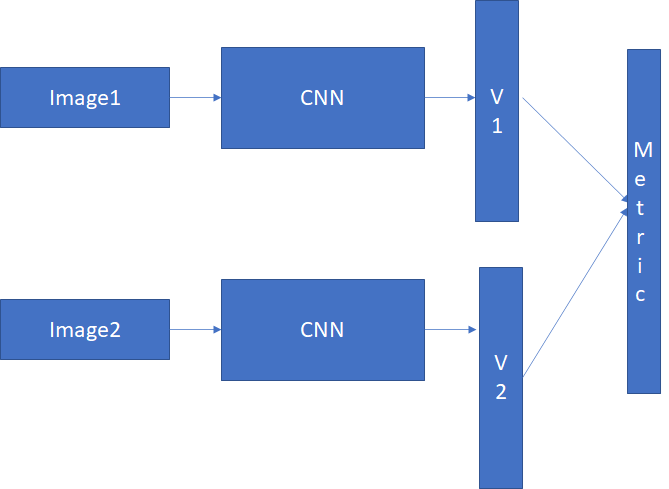

In [6]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3) #input channel = 1 (gray scale), output_channel=4 with kernel size=3,3
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3) #input channel = 4 (gray scale), output_channel=8 with kernel size=3,3
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3)  #input channel = 8 (gray scale), output_channel=8 with kernel size=3,3
        self.relu = nn.ReLU(inplace=True)  # relu layer to introduce non linearity
        self.batch_norm1 = nn.BatchNorm2d(4)  #batch normalisation applied to first conv1 layer
        self.batch_norm2 = nn.BatchNorm2d(8)  #batch normalisation applied to first and second conv layer
        self.fc1 = nn.Linear(8 * 100 * 100, 500)  # 100 *100 from image dimension input channel=8*100*100 output channel=500
        self.fc2 = nn.Linear(500, 500)  #input channel=500 output channel=500
        self.fc3 = nn.Linear(500, 5)  #input channel=500 output channel=5
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x)))) # input images is passed through reflection padding layer
                                                                            # then through conv1 layer then through relu and batch_norm 
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)  # after passing through each layer the layer output is reshaped to feed into Fully connected layer
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

#The Contrastive loss gives how the newtork is telling twom images are similar or noy
𝑌∗𝐷^2+(1−𝑌)∗max⁡〖(𝑚𝑎rgin−D, 0)^2 〗

Y value is the label. It will be 1 if the image pairs are of the same class, and it will be 0 if the image pairs are of a different class.

In [7]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        return contrastive_loss

In [8]:
dataloader = DataLoader(created_dataset, shuffle=True, num_workers=0, batch_size=train_batch_size)
model = CustomNetwork().cuda()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 1.3708746433258057
Epoch: 0 	 Loss: 1.2810266017913818
Epoch: 0 	 Loss: 1.0816216468811035
Epoch: 0 	 Loss: 1.3880220651626587
Epoch: 0 	 Loss: 1.1640236377716064
Epoch: 0 	 Loss: 1.1436669826507568
Epoch: 0 	 Loss: 1.8603899478912354
Saving model
-- Model Checkpoint saved ---
Epoch: 1 	 Loss: 1.2438960075378418
Epoch: 1 	 Loss: 2.351067066192627
Epoch: 1 	 Loss: 1.1910603046417236
Epoch: 1 	 Loss: 1.0617913007736206
Epoch: 1 	 Loss: 1.1727066040039062
Epoch: 1 	 Loss: 1.1827718019485474
Epoch: 1 	 Loss: 1.3411859273910522
Saving model
-- Model Checkpoint saved ---
Epoch: 2 	 Loss: 0.9815319776535034
Epoch: 2 	 Loss: 1.131134033203125
Epoch: 2 	 Loss: 1.162858486175537
Epoch: 2 	 Loss: 1.1428370475769043
Epoch: 2 	 Loss: 1.0002995729446411
Epoch: 2 	 Loss: 1.1371848583221436
Epoch: 2 	 Loss: 1.29237961769104
Saving model
-- Model Checkpoint saved ---
Epoch: 3 	 Loss: 1.1083978414535522
Epoch: 3 	 Loss: 1.1216398477554321
Epoch: 3 	 Loss: 0.9760907292366028
Epoch: 3 	 L

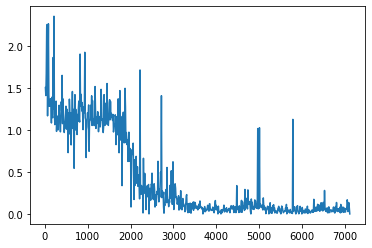

In [13]:
for epoch in range(train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
    print("Saving model")
    torch.save(model, 'model_triplet_pr_po_max_pool_fix_weighted.pt')
    print("-- Model Checkpoint saved ---")

            
show_plot(counter, loss_history)